# Tutorial For Random Forest Classification with Hyperparameter Tuning and Handling Imbalanced Data
### By - Chakshu Sharma (23081435)   [View this project on GitHub](https://github.com/csharma01/Heart-Failure-Data-Random_forest-Classifier-Tutorial)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# check for missing values
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

#### Our Dataset has no missing Values so we can proceed with the model ahead.

In [4]:
print(df['DEATH_EVENT'].value_counts()/len(df))
df['DEATH_EVENT'].value_counts()

DEATH_EVENT
0    0.67893
1    0.32107
Name: count, dtype: float64


DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

#### A class imbalance was discovered in the target variable, this might produce inaccurate results

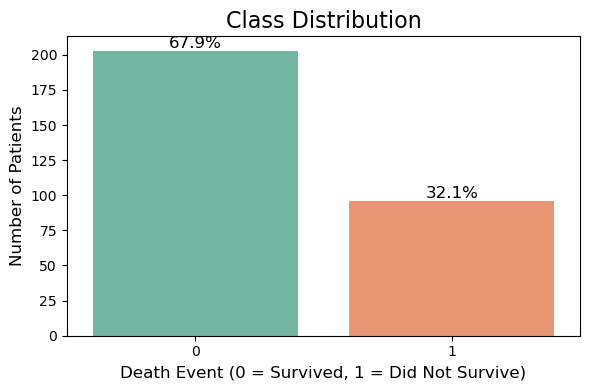

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='DEATH_EVENT', data=df, palette='Set2')

plt.title('Class Distribution', fontsize=16)
plt.xlabel('Death Event (0 = Survived, 1 = Did Not Survive)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

# Show percentages on bars
total = len(df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(), percentage,
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [6]:
# Separate features and target
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf_simple = RandomForestClassifier(random_state=42)
rf_simple.fit(X_train, y_train)

y_pred_simple = rf_simple.predict(X_test)
print('Random Forest Classification Report')
print(classification_report(y_test, y_pred_simple))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        53
           1       0.81      0.57      0.67        37

    accuracy                           0.77        90
   macro avg       0.78      0.74      0.74        90
weighted avg       0.77      0.77      0.76        90



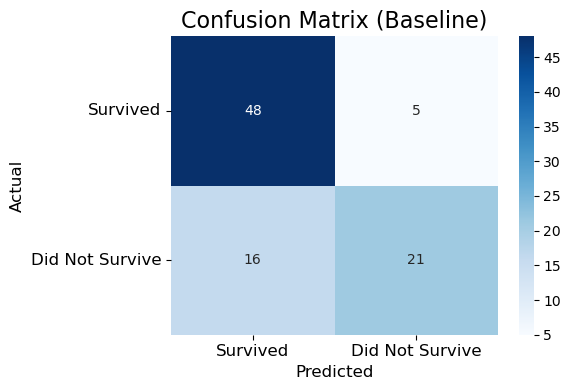

In [7]:
# Plot confusion matrix
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred_simple)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Titles and labels
plt.title('Confusion Matrix (Baseline)', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks([0.5, 1.5], ['Survived', 'Did Not Survive'], fontsize=12)
plt.yticks([0.5, 1.5], ['Survived', 'Did Not Survive'], fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


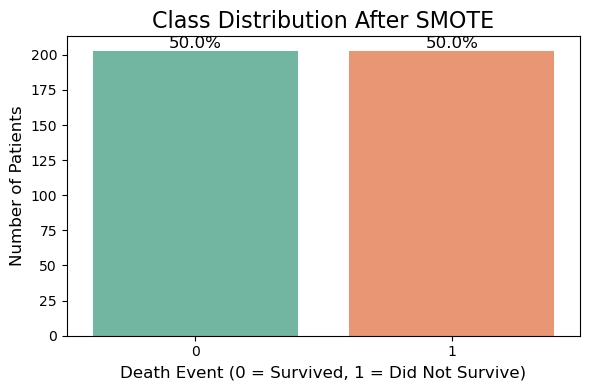

In [8]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df = pd.get_dummies(df, drop_first=True)

X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

# Plot balanced classes after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_sm, palette='Set2')

plt.title('Class Distribution After SMOTE', fontsize=16)
plt.xlabel('Death Event (0 = Survived, 1 = Did Not Survive)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)

total = len(y_sm)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.text(p.get_x() + p.get_width() / 2., p.get_height(), percentage,
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

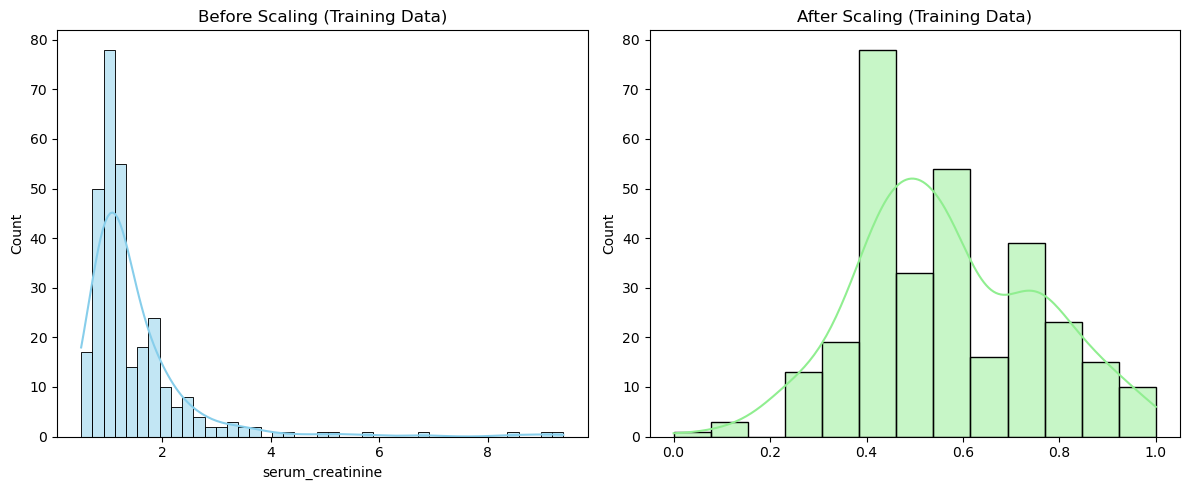

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.25, random_state=42, stratify=y_sm
)

pt = PowerTransformer(method='yeo-johnson')
X_train_pt = pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)

mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train_pt)
X_test_scaled = mm.transform(X_test_pt)

feature_index = 7 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before Scaling 
sns.histplot(X_train.iloc[:, feature_index], ax=axes[0], kde=True, color='skyblue')
axes[0].set_title('Before Scaling (Training Data)')

# After Scaling 
sns.histplot(X_train_scaled[:, feature_index], ax=axes[1], kde=True, color='lightgreen')
axes[1].set_title('After Scaling (Training Data)')

plt.tight_layout()
plt.show()

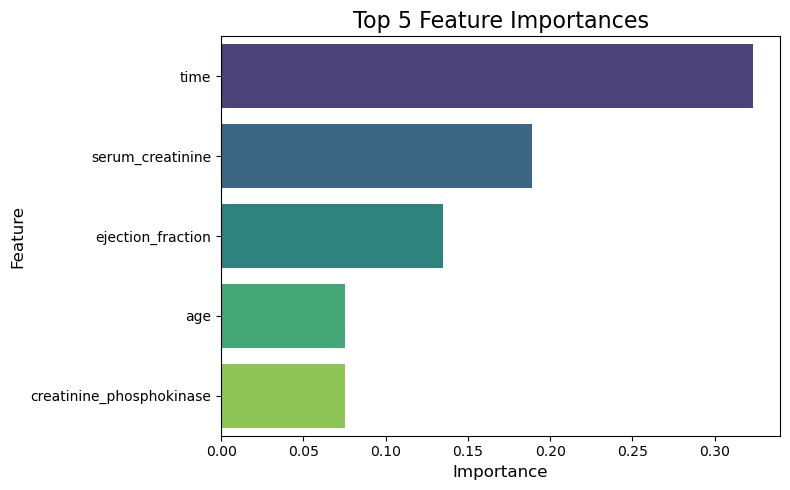

In [10]:
rf_feature = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_feature.fit(X_train_scaled, y_train)

# Extract and sort feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_feature.feature_importances_
}).sort_values(by='importance', ascending=False)

# Top 5 important features visualization
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feature_importances.head(5), palette='viridis')

plt.title('Top 5 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


In [11]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': np.arange(2, 20),
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['gini', 'entropy']
}
search = RandomizedSearchCV(
    rf, param_dist, scoring='f1', n_iter=30, cv=10, random_state=42, n_jobs=-1
)
search.fit(X_train_scaled, y_train)

print('Best hyperparameters:', search.best_params_)

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 13, 'criterion': 'gini'}


Random Forest with Tuning
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        51
           1       0.87      0.92      0.90        51

    accuracy                           0.89       102
   macro avg       0.89      0.89      0.89       102
weighted avg       0.89      0.89      0.89       102



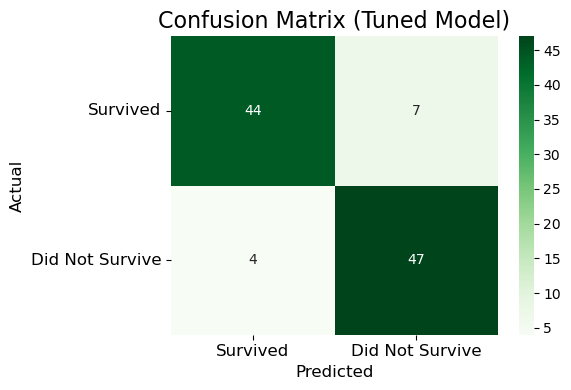

In [12]:
y_pred_advanced = search.predict(X_test_scaled)
print('Random Forest with Tuning')
print(classification_report(y_test, y_pred_advanced))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_advanced), annot=True, fmt='d', cmap='Greens')

plt.title('Confusion Matrix (Tuned Model)', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks([0.5, 1.5], ['Survived', 'Did Not Survive'], fontsize=12)
plt.yticks([0.5, 1.5], ['Survived', 'Did Not Survive'], fontsize=12, rotation=0)
plt.tight_layout()
plt.show()